# 인구 조사 데이터로 인종 예측하기

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [60]:
df = pd.read_csv('./datasets/adult/adult.data', header=None)
df.shape

(32561, 15)

In [61]:
df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


In [62]:
race = df[8]
set(race)

{' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Black', ' Other', ' White'}

In [63]:
# 1. 누락처리
df.isna().sum().sum()

0

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
0     32561 non-null int64
1     32561 non-null object
2     32561 non-null int64
3     32561 non-null object
4     32561 non-null int64
5     32561 non-null object
6     32561 non-null object
7     32561 non-null object
8     32561 non-null object
9     32561 non-null object
10    32561 non-null int64
11    32561 non-null int64
12    32561 non-null int64
13    32561 non-null object
14    32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [65]:
# 2. xy분리
x = df.drop(columns=[2, 8])
y = race.map({' Amer-Indian-Eskimo':0, ' Asian-Pac-Islander':1, ' Black':2, ' Other':3, ' White':4}) 
x.shape, y.shape

((32561, 13), (32561,))

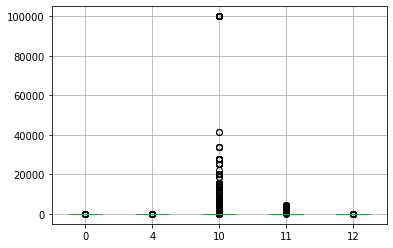

In [66]:
x.boxplot()
# 10번 컬럼에 이상치가 있다 -> min/max보다는 정규분포 정규화로

In [67]:
# 3. 원핫인코딩
x = pd.get_dummies(x)
x.shape 

(32561, 104)

In [68]:
# 4. sklearn - LogisticRegression으로 학습 및 성능 체크
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(x, y)
model.score(x, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8734989711618194

In [69]:
# 5. tensorflow로 구현 => numpy만 호환 가능하여서 형확인 및 형변환이 필수!!

In [70]:
type(x), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [71]:
x = np.array(x) #np.arra
y = np.array(y)
type(x), type(y)

(numpy.ndarray, numpy.ndarray)

In [72]:
y.shape

(32561,)

In [73]:
y_2d = y.reshape([-1, 1]) # y를 길게 만들기
y_2d

array([[4],
       [4],
       [4],
       ...,
       [4],
       [4],
       [4]], dtype=int64)

In [74]:
from sklearn.preprocessing import OneHotEncoder
y_hot = OneHotEncoder().fit_transform(y_2d)
y_hot = y_hot.toarray()
y_hot

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [75]:
w = tf.Variable(tf.random_normal(shape=[104, 5]))
b = tf.Variable(tf.random_normal(shape=[5]))

x = tf.cast(x, tf.float32)

xn = x / tf.reduce_max(x)
##x = x.astype(tf.float32)



## xmin = np.min(x_dumm, axis=0)
## xmax = np.max(x_dumm, axis=0)
## xn = (x - xmin) / (xmax-xmin)
z = tf.matmul(xn, w)
## z = tf.matmul(xn, w) + b
h = tf.nn.softmax(z)
h = tf.clip_by_value(h, 1e-8, 1- 1e-8) # log(0)이 되지 않도록 안전장치
cost = -tf.reduce_mean(y_hot * tf.log(h) + (1-y_hot) * tf.log(1-h))
predict_class = tf.math.argmax(h, axis=1, output_type=tf.int32) # [0, 2]
accuracy = tf.reduce_mean(tf.cast(tf.equal(predict_class, y), tf.float32))
train = tf.train.GradientDescentOptimizer(0.5).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [76]:
for i in range(10000):
    _, c, a = sess.run([train, cost, accuracy])
    if i%500==0:
        print(i, c, a)

0 0.50165063 0.026934063
500 0.50037444 0.026964774
1000 0.49919918 0.027026197
1500 0.49816853 0.095451616
2000 0.49731553 0.09572802
2500 0.49663532 0.096219406
3000 0.49609488 0.097724274
3500 0.49565685 0.11179018
4000 0.49529108 0.1359909
4500 0.49497634 0.13786432
5000 0.49469832 0.13924634
5500 0.49444705 0.14118117
6000 0.49421608 0.14299315
6500 0.49400082 0.1449894
7000 0.4937979 0.1476306
7500 0.49360508 0.15060963
8000 0.49342042 0.1537115
8500 0.4932429 0.15733546
9000 0.49307138 0.16160437
9500 0.49290514 0.1664568


In [79]:
weight = sess.run(w)
xn = np.array(xn)
col_name = pd.get_dummies(xn).columns.values
d = pd.DataFrame(weight)
d_t = d.T
d_t.columns = col_name
d_t.index=set(race)

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
d_t